In [12]:
import numpy as np
import matplotlib.pyplot as plt
import os #untuk mport dataset
from math import log #rumus glcm
import cv2 as cv
import pandas as pd #untuk nampilin data frame
from math import ceil
from sklearn import datasets 
from sklearn.model_selection import train_test_split 
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## DISPLAY IMAGE

In [13]:
def tampilkanGambar(images, titles, row, col):
    plt.figure(figsize=(10,10))
    for i in range(row):
        for j in range (col):
            plt.subplot(row,col,i*col+(j+1))
            plt.grid(color="none")
            plt.imshow(images[i*col+j],'gray')
            plt.title(titles[i*col+j])
    plt.tight_layout()
    plt.show()

## FILTERING

In [14]:
def sorting(arr): #di sort ini harus jd 1 array
    for i in range(len(arr)): 
        swap = i + np.argmin(arr[i:])
        (arr[i], arr[swap]) = (arr[swap], arr[i])
    return arr

In [15]:
def flatArray(arr): #buat jadiin array 1 dimensi
    row, col = arr.shape 
    flat=[]
    for i in range (row):
        for j in range (col):
            flat.append(arr[i][j]) #buat nambahin nilai ke list
    return flat

In [16]:
def median(image,windowHeight,windowWidth):
    pad = np.pad(image,(windowHeight,windowWidth),mode='edge')
    median = np.zeros(image.shape, dtype=np.uint8)
    for i in range(windowHeight,len(pad)-windowHeight):
        for j in range(windowWidth,len(pad)-windowWidth):
            window = flatArray(pad[i-windowHeight:i,j-windowWidth:j])
            window = sorting(window)
            median[i-windowHeight,j-windowWidth] = window[ceil(len(window)/2)]
    return median

## MORFOLOGY OPERATION (erosi)

In [17]:
def fit(window,SE): 
    for i in range(len(SE)):
      for j in range(len(SE)):
        if(SE[i][j]==1 and window[i][j]==0): 
          return 0
    return 1
def erosi(image,SE):
    erosi = np.zeros(image.shape, dtype=np.uint8)
    row, col = image.shape
    # melakukan perulangan pada window center image
    for i in range(row-len(SE)):
        for j in range(col-len(SE)):
            window = image[i:i+len(SE),j:j+len(SE)]
            # mengambil nilai pada fungsi fit, jika fit maka bernilai 1 jika tidak maka 0
            erosi[i][j] = fit(window,SE)
    return erosi

In [24]:
def convertBinary(image):
    ret, binary = cv.threshold(image,30,255,cv.THRESH_BINARY)
    return binary

In [25]:
def getParasite(image):
    ret,parasit = cv.threshold(image,118,255,cv.THRESH_BINARY)
    parasit-=255
    return parasit

In [26]:
SE = [[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]]

## SEGMENTATION

In [27]:
def segmentation(mainImage, grayImage): #buat maskingnya 
    parasite=getParasite(grayImage)
    erode = erosi(parasite, SE)
    medParasite = median(erode, 4, 4) 
    maskParasite = cv.bitwise_and(mainImage, mainImage, mask=medParasite) #buat maskingnya
    return maskParasite

## GET DATASET

In [28]:
dataset_dir = "dataset/"
images = []
labels = []
names = []
# Buat folder output
os.makedirs("mask_parasite", exist_ok=True)
notMalaria = 1 #nandain buat mulai dari 1
Malaria = 1 #nandain buat mulai dari 1
for sub_folder in os.listdir(dataset_dir): 
    sub_folder_files = os.listdir(os.path.join(dataset_dir, sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img = cv.imread(os.path.join(dataset_dir, sub_folder, filename))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (255,255))
        gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        maskParasite = segmentation(img, gray)
        if (sub_folder == 'Uninfected'): 
            plt.imsave("mask_parasite/Mask-Not-Malaria-"+str(notMalaria)+".png", maskParasite)
            notMalaria+=1
        else: 
            plt.imsave("mask_parasite/Mask-Malaria-"+str(Malaria)+".png", maskParasite)
            Malaria+=1
        grayParasit = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        images.append(grayParasit)
        labels.append(sub_folder)
        names.append(filename)
images = np.array(images)
labels = np.array(labels)
names = np.array(names)

## PLOTTING 1 IMAGE

In [29]:
imgBGR = cv.imread('dataset/Parasitized/C39P4thinF_original_IMG_20150622_105335_cell_6.png')

In [30]:
imgRGB = cv.cvtColor(imgBGR, cv.COLOR_BGR2RGB)

In [31]:
img = cv.resize(imgRGB, (255,255))

In [32]:
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

In [33]:
parasite=getParasite(gray)

In [34]:
erode = erosi(parasite, SE)

In [35]:
medParasite = median(erode, 4, 4)

In [36]:
maskParasite = cv.bitwise_and(img, img, mask=medParasite)

In [37]:
grayParasite = cv.cvtColor(maskParasite, cv.COLOR_RGB2GRAY)

In [38]:
binaryParasite = convertBinary(grayParasite)

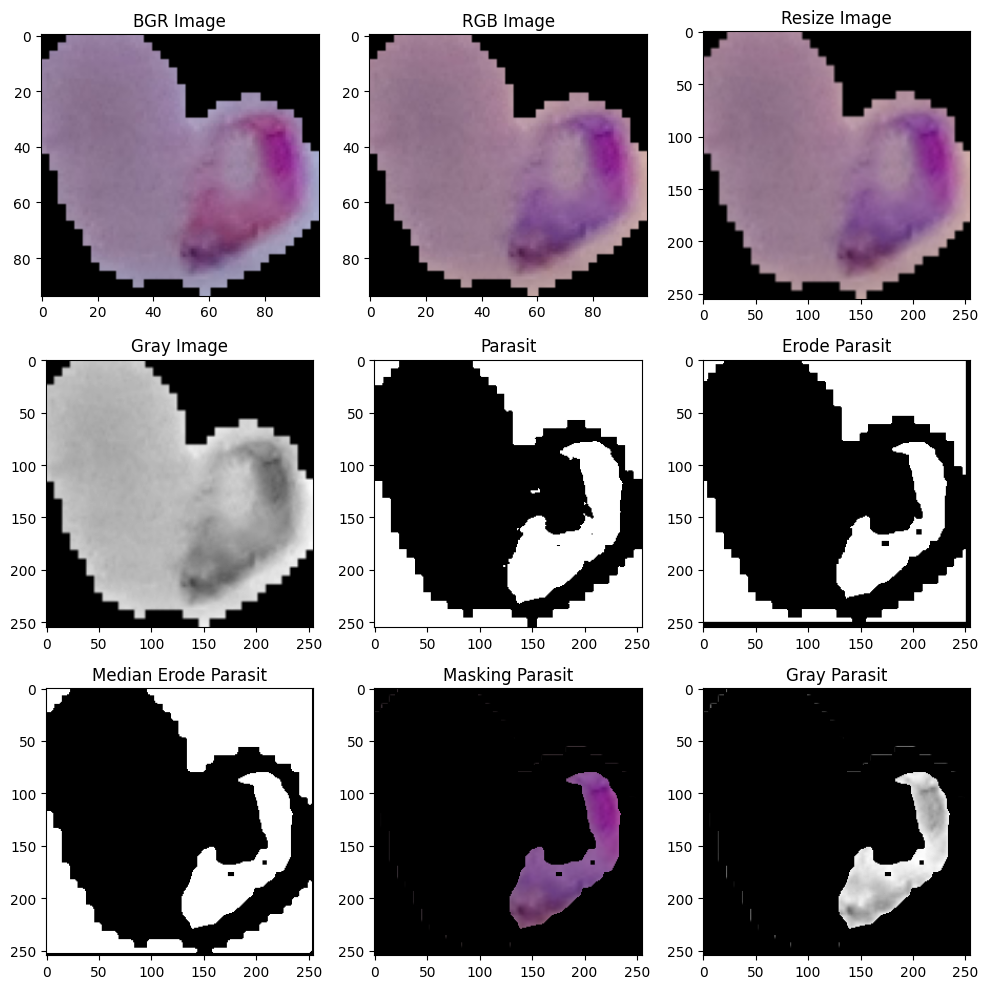

In [40]:
none = np.zeros(img.shape)
img = cv.resize(imgRGB, (255,255))
titles = ['BGR Image','RGB Image', 'Resize Image',
    'Gray Image', 'Parasit', 'Erode Parasit',
    'Median Erode Parasit', 'Masking Parasit', 'Gray Parasit',
    'Binary Parasit', 'None']
hasilimage = [imgBGR,imgRGB, img,
    gray, parasite, erode,
    medParasite, maskParasite, grayParasite,
    binaryParasite, none]
tampilkanGambar(hasilimage, titles, 3, 3)

## GLCM

In [41]:
def transpose(matrix):
    matrix_transpose = []
    row,col = matrix.shape
    for i in range(row):
        mRow = []
        for j in range(col):
            mRow.append(matrix[j][i])
        matrix_transpose.append(mRow)
    return matrix_transpose

In [42]:
def dataSum(image):
    result = 0
    for i in range (len(image)):
        for j in range(len(image)):
            result+=image[i,j]
    return result

In [43]:
def normalization(image):
    row, col = image.shape
    n = dataSum(image)
    for i in range(row):
        for j in range(col):
            image[i,j]/=n
    return image

In [44]:
def cooccurance (image, dimention, degree):
    row, col = image.shape
    matrixCo = np.zeros([dimention+1,dimention+1])
    if(degree == 0):
        for i in range(row):
            for j in range(col):
                if(j+1 < col):
                    matrixCo[image[i,j], image[i,j+1]] += 1
    elif (degree == 45):
        for i in range(row):
            for j in range(col):
                if(i-1 >= 0 and j+1 < col):
                    matrixCo[image[i,j], image[i-1,j+1]] += 1
    elif (degree == 90):
        for i in range(row):
            for j in range(col):
                if(i+1 < row and j+1 < col):
                    matrixCo[image[i,j], image[i+1,j]] += 1
    elif (degree == 135):
        for i in range(row):
            for j in range(col):
                if(i+1 < row and j+1 < col):
                    matrixCo[image[i,j], image[i+1,j+1]] += 1
    trans = transpose(matrixCo)
    sumMatrix = matrixCo+trans
    glcm = normalization(sumMatrix)
    return glcm

In [45]:
def mean(image):
    meanX=meanY= 0
    for i in range (len(image)):
        for j in range(len(image)):
            meanX += i * image[i,j]
            meanY += j * image[i,j]
    return meanX, meanY
def tao(image):
    taoX=taoY=0
    meanX,meanY= mean(image)
    for i in range (len(image)):
        for j in range(len(image)):
            taoX += pow((i-meanX),2)*image[i,j]
            taoY += pow((j-meanY),2)*image[i,j]
    return taoX, taoY
def extraction(image):
    energy=homogenity=entropy=contrast=disimilarity=correlation=ASM=0
    meanX, meanY = mean(image)
    taoX, taoY = tao(image)
    for i in range (len(image)):
        for j in range (len(image)):
            contrast += image[i,j]*pow((i-j),2)
            disimilarity += image[i,j]*abs(i-j)
            # homogenity += image[i,j]/1+(pow((i-j),2))
            homogenity += image[i,j]/1+abs(i-j)
            if image[i,j] > 0:
                entropy += -(image[i,j] * log(image[i,j]))
            ASM += pow(image[i,j],2)
            correlation+=((i-meanX)*(j-meanY)*image[i,j])/pow((taoX*taoY),1/2)
    energy = pow(ASM, 1/2)
    return contrast,disimilarity,homogenity,entropy,ASM,energy,correlation

In [46]:
def getGLCM(images):
    glcmImage = []
    for i in range(len(images)):
        glcm = []
        max = images[i].max()
        glcm.append(cooccurance(images[i],max,0))
        glcm.append(cooccurance(images[i],max,45))
        glcm.append(cooccurance(images[i],max,90))
        glcm.append(cooccurance(images[i],max,135))
        glcmImage.append(glcm)
    return glcmImage

In [47]:
csv = []
index = 0
for i in getGLCM(images):
    extract = []
    extract.append(names[index])
    extract.append(labels[index])
    index+=1
    for img in i:
        contrast,disimilarity,homogenity,entropy,ASM,energy,correlation = extraction(img)
        extract.append(contrast)
        extract.append(disimilarity)
        extract.append(homogenity)
        extract.append(entropy)
        extract.append(ASM)
        extract.append(energy)
        extract.append(correlation)
    csv.append(extract)

In [48]:
header = ['Name','Label','Contrast0','Dissimilarity0','Homogenity0','Entropy0','ASM0','Energy0','Correlation0'
           ,'Contrast45','Dissimilarity45','Homogenity45','Entropy45','ASM45','Energy45','Correlation45'
           ,'Contrast90','Dissimilarity90','Homogenity90','Entropy90','ASM90','Energy90','Correlation90'
           ,'Contrast135','Dissimilarity135','Homogenity135','Entropy135','ASM135','Energy135','Correlation135']
df = pd.DataFrame(csv, columns=header)

In [49]:
df.to_csv(r'resul.csv', index=False)

In [ ]:
# Tampilkan DataFrame dengan format yang lebih baik
# Atur agar semua baris dan kolom muncul
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Tampilkan DataFrame
df  # atau cukup ketik df jika di Jupyter


,Name,Label,Contrast0,Dissimilarity0,Homogenity0,Entropy0,ASM0,Energy0,Correlation0,Contrast45,Dissimilarity45,Homogenity45,Entropy45,ASM45,Energy45,Correlation45,Contrast90,Dissimilarity90,Homogenity90,Entropy90,ASM90,Energy90,Correlation90,Contrast135,Dissimilarity135,Homogenity135,Entropy135,ASM135,Energy135,Correlation135
0,C33P1thinF_IMG_20150619_114756a_cell_179.png,Parasitized,149.612475,2.398827,3549261.0,4.795772,0.076175,0.275999,0.988636,301.193533,4.031124,3549261.0,5.077609,0.072015,0.268357,0.977003,165.329035,2.446959,3549261.0,4.833491,0.074650,0.273221,0.987377,303.956166,4.087172,3549261.0,5.087551,0.071993,0.268315,0.976792
1,C33P1thinF_IMG_20150619_114756a_cell_180.png,Parasitized,122.194087,2.174417,3746401.0,4.340339,0.073014,0.270211,0.990981,267.539711,3.808575,3746401.0,4.621457,0.067485,0.259780,0.980120,160.263981,2.409123,3746401.0,4.418090,0.070825,0.266130,0.988093,276.865429,3.920454,3746401.0,4.661038,0.067231,0.259290,0.979427
2,C33P1thinF_IMG_20150619_114756a_cell_181.png,Parasitized,140.378493,2.363301,3453339.0,4.976738,0.053036,0.230296,0.986692,277.375969,4.093558,3453339.0,5.263021,0.049456,0.222386,0.973492,145.164285,2.489599,3453339.0,4.997642,0.051912,0.227843,0.986119,269.968473,4.004526,3453339.0,5.256178,0.049434,0.222339,0.974200
3,C33P1thinF_IMG_20150619_114756a_cell_182.png,Parasitized,152.481365,2.236282,4002921.0,4.394755,0.105320,0.324531,0.990521,308.555800,3.927243,4002921.0,4.671634,0.100668,0.317282,0.980747,156.363321,2.328291,4002921.0,4.420632,0.103668,0.321975,0.990242,286.873272,3.728067,4002921.0,4.642486,0.100936,0.317704,0.982100
4,C33P1thinF_IMG_20150619_115740a_cell_161.png,Parasitized,131.949498,2.313463,3501081.0,4.737516,0.072952,0.270096,0.989157,226.511207,3.605416,3501081.0,4.983686,0.069096,0.262862,0.981292,107.973278,2.047151,3501081.0,4.711708,0.072439,0.269144,0.991083,240.407542,3.755394,3501081.0,4.992222,0.069061,0.262794,0.980144
5,C33P1thinF_IMG_20150619_115740a_cell_162.png,Parasitized,84.247846,1.858808,3501081.0,5.031105,0.034887,0.186782,0.990259,167.779094,3.163990,3501081.0,5.323894,0.031737,0.178150,0.980415,93.472642,1.956925,3501081.0,5.008501,0.034341,0.185312,0.989084,164.655713,3.118730,3501081.0,5.288080,0.031946,0.178735,0.980780
6,C33P1thinF_IMG_20150619_115740a_cell_163.png,Parasitized,137.714822,2.206222,3501081.0,4.556048,0.051458,0.226843,0.988025,241.213404,3.444169,3501081.0,4.818362,0.047320,0.217533,0.978861,115.583344,1.863119,3501081.0,4.548378,0.050727,0.225226,0.989871,253.116963,3.553847,3501081.0,4.838047,0.047213,0.217285,0.977818
7,C33P1thinF_IMG_20150619_115808a_cell_205.png,Parasitized,141.883758,2.315007,3043041.0,5.241964,0.054641,0.233754,0.986105,235.977137,3.774614,3043041.0,5.482602,0.051571,0.227092,0.976725,102.019313,2.142941,3043041.0,5.125473,0.054414,0.233269,0.989952,234.778179,3.779078,3043041.0,5.497277,0.051541,0.227027,0.976843
8,C33P1thinF_IMG_20150619_115808a_cell_206.png,Parasitized,108.017184,1.999398,3696449.0,4.733853,0.051972,0.227974,0.989885,245.607601,3.627627,3696449.0,5.001001,0.047914,0.218893,0.976786,152.994063,2.446788,3696449.0,4.762317,0.050529,0.224786,0.985547,254.474859,3.761021,3696449.0,5.036495,0.047676,0.218349,0.975948
9,C33P1thinF_IMG_20150619_120645a_cell_215.png,Parasitized,120.565725,2.021090,3597881.0,4.439521,0.070666,0.265830,0.990254,248.737367,3.517112,3597881.0,4.715159,0.065933,0.256774,0.979762,146.770755,2.251287,3597881.0,4.503049,0.069027,0.262730,0.988070,267.888183,3.708599,3597881.0,4.747124,0.065661,0.256244,0.978204


In [ ]:
df

,Name,Label,Contrast0,Dissimilarity0,Homogenity0,Entropy0,ASM0,Energy0,Correlation0,Contrast45,...,ASM90,Energy90,Correlation90,Contrast135,Dissimilarity135,Homogenity135,Entropy135,ASM135,Energy135,Correlation135
0,C33P1thinF_IMG_20150619_114756a_cell_179.png,Parasitized,149.612475,2.398827,3549261.0,4.795772,0.076175,0.275999,0.988636,301.193533,...,0.074650,0.273221,0.987377,303.956166,4.087172,3549261.0,5.087551,0.071993,0.268315,0.976792
1,C33P1thinF_IMG_20150619_114756a_cell_180.png,Parasitized,122.194087,2.174417,3746401.0,4.340339,0.073014,0.270211,0.990981,267.539711,...,0.070825,0.266130,0.988093,276.865429,3.920454,3746401.0,4.661038,0.067231,0.259290,0.979427
2,C33P1thinF_IMG_20150619_114756a_cell_181.png,Parasitized,140.378493,2.363301,3453339.0,4.976738,0.053036,0.230296,0.986692,277.375969,...,0.051912,0.227843,0.986119,269.968473,4.004526,3453339.0,5.256178,0.049434,0.222339,0.974200
3,C33P1thinF_IMG_20150619_114756a_cell_182.png,Parasitized,152.481365,2.236282,4002921.0,4.394755,0.105320,0.324531,0.990521,308.555800,...,0.103668,0.321975,0.990242,286.873272,3.728067,4002921.0,4.642486,0.100936,0.317704,0.982100
4,C33P1thinF_IMG_20150619_115740a_cell_161.png,Parasitized,131.949498,2.313463,3501081.0,4.737516,0.072952,0.270096,0.989157,226.511207,...,0.072439,0.269144,0.991083,240.407542,3.755394,3501081.0,4.992222,0.069061,0.262794,0.980144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,C2NThinF_IMG_20150604_114730_cell_72.png,Uninfected,106.736576,1.668643,2587399.0,3.536954,0.099800,0.315911,0.991661,229.656984,...,0.097266,0.311875,0.989537,237.041137,3.222053,2587399.0,3.780784,0.091909,0.303165,0.981387
196,C2NThinF_IMG_20150604_114730_cell_98.png,Uninfected,122.808013,1.793160,2747403.0,3.876571,0.110414,0.332286,0.990508,237.991692,...,0.108424,0.329278,0.990862,227.070029,3.018259,2747403.0,4.117442,0.104866,0.323830,0.982390
197,C2NThinF_IMG_20150604_114751_cell_38.png,Uninfected,106.315486,1.668797,2666601.0,3.879934,0.074012,0.272051,0.990705,199.353013,...,0.072668,0.269570,0.990996,204.950012,2.929428,2666601.0,4.123148,0.068147,0.261050,0.981966
198,C2NThinF_IMG_20150604_114751_cell_69.png,Uninfected,96.505743,1.556044,2706801.0,3.830664,0.067040,0.258922,0.991475,191.611879,...,0.066010,0.256925,0.991391,184.068262,2.757146,2706801.0,4.033986,0.061247,0.247482,0.983627


In [ ]:
y = df['Label']
X = df.drop(['Label', 'Name'], axis = 1)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#apply PCA
pca = PCA(n_components=4)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25)

In [ ]:
model = svm.SVC()
model.fit(X_train, y_train)
# predicting the response for test dataset
y_pred = model.predict(X_test)

In [ ]:
# reporting model accuracy
print("Accuracy:", round(accuracy_score(y_test, y_pred)*100),'%')

Accuracy: 96 %


In [ ]:
y_pred

array(['Parasitized', 'Uninfected', 'Parasitized', 'Uninfected',
       'Parasitized', 'Uninfected', 'Uninfected', 'Uninfected',
       'Parasitized', 'Parasitized', 'Uninfected', 'Uninfected',
       'Parasitized', 'Uninfected', 'Uninfected', 'Uninfected',
       'Parasitized', 'Parasitized', 'Uninfected', 'Uninfected',
       'Parasitized', 'Uninfected', 'Uninfected', 'Uninfected',
       'Parasitized', 'Parasitized', 'Uninfected', 'Uninfected',
       'Uninfected', 'Uninfected', 'Parasitized', 'Uninfected',
       'Parasitized', 'Parasitized', 'Parasitized', 'Uninfected',
       'Uninfected', 'Uninfected', 'Parasitized', 'Parasitized',
       'Parasitized', 'Parasitized', 'Uninfected', 'Uninfected',
       'Parasitized', 'Uninfected', 'Parasitized', 'Uninfected',
       'Uninfected', 'Parasitized'], dtype=object)

In [ ]:
y_test

45     Parasitized
104     Uninfected
87     Parasitized
106     Uninfected
10     Parasitized
195     Uninfected
147     Uninfected
194     Uninfected
71     Parasitized
48     Parasitized
113     Uninfected
153     Uninfected
6      Parasitized
193     Uninfected
118     Uninfected
196     Uninfected
17     Parasitized
42     Parasitized
175     Uninfected
154     Uninfected
56     Parasitized
119     Uninfected
179     Uninfected
166     Uninfected
11     Parasitized
30     Parasitized
199     Uninfected
108     Uninfected
89     Parasitized
125     Uninfected
20     Parasitized
122     Uninfected
160     Uninfected
74     Parasitized
35     Parasitized
185     Uninfected
132     Uninfected
145     Uninfected
54     Parasitized
80     Parasitized
24     Parasitized
44     Parasitized
110     Uninfected
155     Uninfected
62     Parasitized
142     Uninfected
58     Parasitized
151     Uninfected
181     Uninfected
28     Parasitized
Name: Label, dtype: object

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 Parasitized       0.95      0.95      0.95        22
  Uninfected       0.96      0.96      0.96        28

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

